## Reducing Dimensionality

There are two main drivers of dimensionality in this dataset: Keywords and Production Companies

Both bring thousands of dummy variables and create a sparse matrix that must be used for modelling.  I have several other categories that increase dimensionality more than they should, from these I need to severely reduce the number of features that are present in my data.  I'll list the general approach for each here, and enumerate why I'm taking that approach in subsections below. 

**Keywords:** Eliminate any keyword that appears in less than fifty films, reducing to 23 features

**Production Companies:** Bin this by quartiles, reducing to 4 features

**Release Year:** Bin by decade, reducing to 6 features

**Production Country:** Eliminate and create a single column indicating if a film was produced in the US or not

Once I've reduced the dimensionality appropriately I'll test the performance of linear, random forest, gradient boosting, xgboost, and k-nearest neighbors regression models. I will also compare model performance using RMSE and R-squared metrics as well as examining the models residual plots. 

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [8]:
boxoffice = pd.read_csv('../Data/No_Outliers.csv', index_col=0, header=[0,1])

In [9]:
# Copying the boxoffice dataframe prior to making major changes so that I have access to all the information
# if any mistakes are made. 
box = boxoffice
box.shape

(2216, 9976)

### Keywords

The Keywords category adds 7,134 dimensions to this data set and is incredibly sparse.  Only 1000 keywords actually appear in more than 5 films.  As a starting point I'm going to eliminate all keywords that don't appear in in at least 50 films, which reduces this category by 7,123 dimensions to 11 features. 

I would prefer to bin keywords by quartiles as I'll do with production companies. This presents problems to stakeholders who would like to make predictions from this model for a film's revenue.  If keywords are binned by revenue, you need to consult the existing list of keywords to identify which quartile a keywords belongs to.  This by itself isn't a problem.  However, over half of all keywords appear in only a single film, and many are a garbled collection of symbols that are not interpretable. A single previous data point is not a good predictor of revenue, further compounded by the likelihood that a keyword has not appeared in a single film previously.  

If a keyword has not previously appeared in a film, it's impossible to use prior revenue performance to predict future revenue performance.  As a result, I've chosed to bin keywords by their frequency in the data set. 

In [10]:
sums = boxoffice['Keywords']
sums = sums.sum(axis=1)
# create a new column that indicates the number of keywords that participate in the creation of a film
box['Numerical', 'Num_keywords'] = sums

In [11]:
# Create a list of keywords that appear in more than 50 films
kwrds = boxoffice['Keywords']
count = kwrds.apply(pd.value_counts)
count = count.iloc[1]
pd.DataFrame(count)
new_cols = list(count[count>=50].index)

In [12]:
# drops all keyword columns that don't appear in more than 50 films
old_cols = list(box['Keywords'].columns)
old_cols = set(old_cols)
new_cols = set(new_cols)
drop = old_cols.difference(new_cols)
drop = list(drop)
box.drop(drop, axis=1, level=1, inplace=True)
box.drop('No Keywords', axis=1, level=1, inplace=True)
box.shape

(2216, 2857)

### Production Companies

Next, I need to bin production companies by revenue tier.  This will involve reducing the 2,688 features for Production Companies down to 4 features for production company revenue quartiles. These will indicate if a film has a production company who's fims are generally in the 25th, 50th, 75th, or 100th quartile of film revenue. 

I'm also going to sum up all the rows for production companies and create a new column that indicates the number of companies that contribute to a film since each film can have multiple companies working on it.

In [13]:
sums = boxoffice['Company']
sums = sums.sum(axis=1)
# create a new column that indicates the number of companies that participate in the creation of a film
box['Numerical', 'Num_companies'] = sums

In [14]:
# Creating a dataframe of the production company data joined with revenue data
rev = boxoffice['Numerical', 'revenue']
rev = pd.DataFrame(rev)
rev.columns = rev.columns.droplevel()
prod_co = boxoffice['Company']
prod_co_rev = prod_co.join(rev)

In [15]:
# Creating a series that lists companies by the average revenue they produce
median={}
for x in prod_co_rev:
    median[x] = prod_co_rev['revenue'][prod_co_rev[x] == 1].median()
medians = pd.Series(median)
medians.sort_values(ascending=False)

LEGO                               468760692.00000
Groucho II Film Partnership        463517383.00000
thinkfilm                          459359555.00000
XM3 Service                        459359555.00000
X3US Productions                   459359555.00000
                                         ...      
The Donners' Company                           NaN
Theobald Film Productions                      NaN
Vita-Ray Dutch Productions (III)               NaN
Warner Bros. Pictures                          NaN
revenue                                        NaN
Length: 2689, dtype: float64

Interesting that film companies have no revenue. However this would indicate that these companies simply don't have films observed in the data set.  This is not that surprising considering that in the previous notebook I eliminated 5% of the observations.  It is surprising that Warner Bros. is one of those companies with no films present, however it is reasonable that Warner Bros films would be in the top 5% of revenue since it's one of the most well-known companies.

In [16]:
# verifying that the number of production companies with less than 5%
print('Number of film companies with no films: ', medians.isnull().sum())
print('% of film companies with no films: ' + str(medians.isnull().sum() / len(medians)))

Number of film companies with no films:  39
% of film companies with no films: 0.014503532911863145


In [17]:
# creating a list of production company names to drop later since their films have been dropped from the data set
mask = medians.isnull()
droplist = list(medians[mask].index)
# Edit the series to 
reverse = medians[medians.notnull()]
reverse = reverse.sort_values(ascending=False)
reverse.shape

(2650,)

In [18]:
# Cutting the list of companies & revenue into quartiles
reverse = pd.DataFrame(reverse, columns = ['revenue'])
reverse['Quartile'] = pd.qcut(reverse['revenue'], q=4, labels=False)
# Creating a list of company names for each quartile
quartile_1st = list(reverse[reverse['Quartile'] == 0].index)
quartile_2nd = list(reverse[reverse['Quartile'] == 1].index)
quartile_3rd = list(reverse[reverse['Quartile'] == 2].index)
quartile_4th = list(reverse[reverse['Quartile'] == 3].index)

In [19]:
# Nested for loops that create new columns that indicate if a film was contributed to by a production company who's average film
# revenue is in the 1st, 2nd, 3rd, or 4th quartiles
for i in quartile_1st:
    for k in prod_co.index:
        if prod_co.loc[k,i] == 1:
            box.loc[k, ('Company', 'Company_quartile_1st')] = 1
            
for i in quartile_2nd:
    for k in prod_co.index:
        if prod_co.loc[k,i] == 1:
            box.loc[k, ('Company', 'Company_quartile_2nd')] = 1
        
for i in quartile_3rd:
    for k in prod_co.index:
        if prod_co.loc[k,i] == 1:
            box.loc[k, ('Company', 'Company_quartile_3rd')] = 1
        
for i in quartile_4th:
    for k in prod_co.index:
        if prod_co.loc[k,i] == 1:
            box.loc[k, ('Company', 'Company_quartile_4th')] = 1      

In [20]:
co = box['Company']
co = co.apply(pd.value_counts)
co = co.iloc[1]
keep = co[co>50]
keep = pd.DataFrame(keep)
keep = keep.drop(['Company_quartile_1st', 'Company_quartile_2nd', 'Company_quartile_3rd', 'Company_quartile_4th'], axis=0)
keep = set(list(keep.index))
drop = set(list(prod_co.columns))
drop = list(drop.difference(keep))
box = box.drop(drop, axis=1, level=1)

In [21]:
box['Company'] = box['Company'].fillna(0)
box['Company'] = box['Company'].astype(int)
box.shape

(2216, 186)

### Realease Year

Generally speaking in the exploratory data analysis for this problem I noticed that revenue increased year over year.  This trend can also be captures by features representing the decade for which a film is produced in.  This will reduce the dimensions of the data set by 41 features.

In [22]:
years = boxoffice['Release_year']
years.columns

Index(['1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979',
       '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988',
       '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997',
       '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006',
       '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
       '2016', '2017', 'No Year'],
      dtype='object')

In [23]:
Decade_70s = ['1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979']
Decade_80s = ['1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989']
Decade_90s = ['1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999']
Decade_00s = ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009']
Decade_10s = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']
for i in Decade_70s:
    for k in years.index:
        if years.loc[k,i] == 1:
            box.loc[k, ('Release_year', "70s")] = 1
for i in Decade_80s:
    for k in years.index:
        if years.loc[k,i] == 1:
            box.loc[k, ('Release_year', '80s')] = 1
for i in Decade_90s:
    for k in years.index:
        if years.loc[k,i] == 1:
            box.loc[k, ('Release_year', '90s')] = 1
for i in Decade_00s:
    for k in years.index:
        if years.loc[k,i] == 1:
            box.loc[k, ('Release_year', '00s')] = 1
for i in Decade_10s:
    for k in years.index:
        if years.loc[k,i] == 1:
            box.loc[k, ('Release_year', '10s')] = 1

In [24]:
box = box.drop(['1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979',
       '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988',
       '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997',
       '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006',
       '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
       '2016', '2017'], axis=1, level=1)
box['Release_year'] = box['Release_year'].fillna(0)
box['Release_year'] = box['Release_year'].astype(int)
box.shape

(2216, 144)

### Country

Production country is the last category in this data set that has a sparse matrix of data to work with.  I'm going to group the country information by global region, and I'll also create a new numerical column that indicates if a film was produced in multiple countries.  

This will reduce the data set that I'm working with by 55 features.

In [25]:
sums = boxoffice['Country']
sums = sums.sum(axis=1)
box['Numerical', 'Num_production_countries'] = sums

In [26]:
country = boxoffice['Country']
europe = ['Austria', 'Belgium', 'Bulgaria', 'Czech Republic', 'Denmark', 'Finland', 'France', 'Germany', 'Greece', 
          'Hungary', 'Iceland', 'Ireland', 'Italy', 'Luxembourg', 'Malta', 'Monaco', 'Netherlands', 'Norway', 'Poland', 
          'Portugal', 'Romania', 'Russia', 'Serbia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland']
oceania = ['Australia', 'Indonesia', 'New Zealand', 'Philippines']
asia = ['Cambodia', 'China', 'Hong Kong', 'Japan', 'Singapore', 'South Korea', 'Taiwan', 'Thailand', 'India']
middleast = ['Iran', 'Israel', 'Pakistan', 'Qatar', 'Turkey', 'United Arab Emirates']
latinamerica = ['Argentina', 'Bahamas', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Costa Rica', 'Peru', 'Paraguay',
                'Uruguay', 'Venezuela']
northamerica = ['Canada', 'Mexico']
africa = ['Botswana', 'Mauritania', 'Morocco', 'South Africa']

In [27]:
for i in europe:
    for k in country.index:
        if country.loc[k, i] == 1:
            box.loc[k, ('Country', 'Europe')] = 1
for i in oceania:
    for k in country.index:
        if country.loc[k, i] ==1:
            box.loc[k, ('Country', 'Oceania')] = 1
for i in asia:
    for k in country.index:
        if country.loc[k, i] ==1:
            box.loc[k, ('Country', 'Asia')] = 1
for i in middleast:
    for k in country.index:
        if country.loc[k, i] ==1:
            box.loc[k, ('Country', 'Middle_East')] = 1
for i in latinamerica:
    for k in country.index:
        if country.loc[k, i] ==1:
            box.loc[k, ('Country', 'Latin_America')] = 1
for i in northamerica:
    for k in country.index:
        if country.loc[k, i] ==1:
            box.loc[k, ('Country', 'North_America')] = 1
for i in africa:
    for k in country.index:
        if country.loc[k, i] ==1:
            box.loc[k, ('Country', 'Africa')] = 1

In [28]:
regions = europe + oceania + asia + middleast + latinamerica + northamerica + africa
box = box.drop(regions, level=1, axis=1)
box['Country'] = box['Country'].fillna(0)
box['Country'] = box['Country'].astype(int)
box.shape

(2216, 89)

In [29]:
box = box.drop('No Genre', axis=1, level=1)
box.to_csv('../Data/Reduced_dimensions.csv')

# Testing the performance of regression models on the reduced data set

Now that I've severely reduced the dimensionality of this data I'm going to test a linear, random forest, gradient boosting, Support-Vector, and k-nearest neighbors regression models.

Based on the results from cross-validation I'll then test out of the box models against the test data and plot their residuals as well as calculate the mean absolute percentage error. 

### V 1.0 - due to another project and specialized third party packages I'm currently unable to access scikit-learn 0.24 and thus cannot use mean_absolute_percentage_error within cross-validation

In [30]:
metrics = ['neg_mean_squared_error', 'r2']
# Taking the log of numerical revenue and 
y = np.log(box['Numerical', 'revenue'])
X = box.drop('revenue', level=1, axis=1)
# Scaling the numerical data in X using a standard scaler
scaler=MinMaxScaler()
scaler.fit(X['Numerical'])
X['Numerical'] = scaler.transform(X['Numerical'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# instantiating the regression models
linear = LinearRegression()
random_forest = RandomForestRegressor()
knn = KNeighborsRegressor()
gradient_boost = GradientBoostingRegressor()
svr = LinearSVR()

In [26]:
# Getting linear regression scores
results = cross_validate(linear, X_train, y_train, scoring=metrics)
# takinge the exponential of the RMSE to transform it back into real dollars
RMSE = round(np.exp(np.sqrt(np.mean(np.abs(results['test_neg_mean_squared_error'])))), 5)
R2 = round(np.mean(results['test_r2']), 5)
linear_results = {'RMSE':RMSE, 'R2':R2}
print('Linear RMSE: ', RMSE)
print('Linear R2: ', R2)

Linear RMSE:  inf
Linear R2:  -6.31499072103137e+19


<ipython-input-26-630f51f2bd61>:4: RuntimeWarning: overflow encountered in exp
  RMSE = round(np.exp(np.sqrt(np.mean(np.abs(results['test_neg_mean_squared_error'])))), 5)


In [27]:
# Getting Random Forest scores
results = cross_validate(random_forest, X_train, y_train, scoring=metrics)
RMSE = round(np.exp(np.sqrt(np.mean(np.abs(results['test_neg_mean_squared_error'])))), 5)
R2 = round(np.mean(results['test_r2']), 5)
random_forest_results = {'RMSE':RMSE, 'R2':R2}
print('Random Forest RMSE: ', RMSE)
print('Random Forest R2: ', R2)

Random Forest RMSE:  2.77469
Random Forest R2:  0.55312


In [28]:
# Getting KNN scores
results = cross_validate(knn, X_train, y_train, scoring=metrics)
RMSE = round(np.exp(np.sqrt(np.mean(np.abs(results['test_neg_mean_squared_error'])))), 5)
R2 = round(np.mean(results['test_r2']), 5)
knn_results = {'RMSE':RMSE, 'R2':R2}
print('K-Nearest Neighbor RMSE: ', RMSE)
print('K-Nearest Neighbor R2: ', R2)

K-Nearest Neighbor RMSE:  3.22961
K-Nearest Neighbor R2:  0.40991


In [29]:
# Getting Gradient Boosted scores
results = cross_validate(gradient_boost, X_train, y_train, scoring=metrics)
RMSE = round(np.exp(np.sqrt(np.mean(np.abs(results['test_neg_mean_squared_error'])))), 5)
R2 = round(np.mean(results['test_r2']), 5)
gradient_boosted_results = {'RMSE':RMSE, 'R2':R2}
print('Gradient Boosted RMSE: ', RMSE)
print('Gradient Boosted R2: ', R2)

Gradient Boosted RMSE:  2.75472
Gradient Boosted R2:  0.55983


In [30]:
# Getting Support Vector Regression results
results = cross_validate(svr, X_train, y_train, scoring=metrics)
RMSE = round(np.exp(np.sqrt(np.mean(np.abs(results['test_neg_mean_squared_error'])))), 5)
R2 = round(np.mean(results['test_r2']), 5)
support_vector_results = {'RMSE':RMSE, 'R2':R2}
print('Support Vector RMSE: ', RMSE)
print('Support Vector R2: ', R2)

C:\Users\deann\Anaconda3\envs\general\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\deann\Anaconda3\envs\general\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\deann\Anaconda3\envs\general\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\deann\Anaconda3\envs\general\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Support Vector RMSE:  2.8228
Support Vector R2:  0.53814


C:\Users\deann\Anaconda3\envs\general\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [31]:
# Collecting results for comparison
scores = {'Linear': linear_results, 'Random Forest':random_forest_results, 'KNN':knn_results, 
          'Gradient Boosted':gradient_boosted_results, 'SVR':support_vector_results}
scores = pd.DataFrame(scores)
scores = scores.T
scores = scores.drop('Linear', axis=0)
scores['RMSE'] = scores['RMSE']
scores

,RMSE,R2
Random Forest,2.77469,0.55312
KNN,3.22961,0.40991
Gradient Boosted,2.75472,0.55983
SVR,2.82280,0.53814


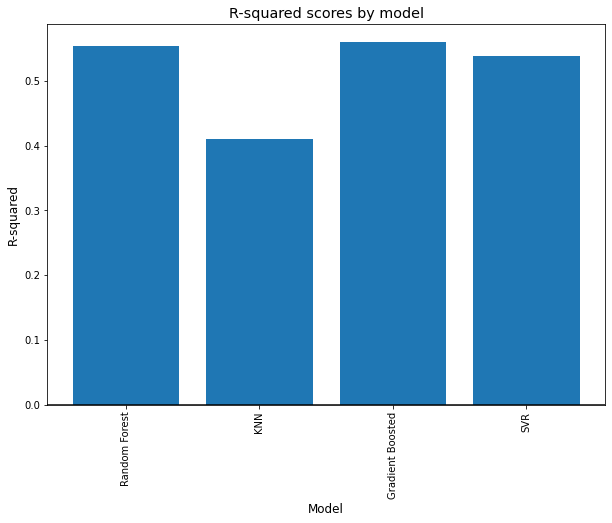

In [32]:
# Linear models are still performing exceptionally poorly - I'm going to drop the data regarding linear model performance
models = list(scores.index)
plt.figure(figsize=(10,7))
plt.bar(models, scores.R2)
plt.xticks(rotation=90)
plt.axhline(0, c='black')
plt.xlabel('Model', size='large')
plt.ylabel('R-squared', size='large')
plt.title('R-squared scores by model', size = 'x-large');

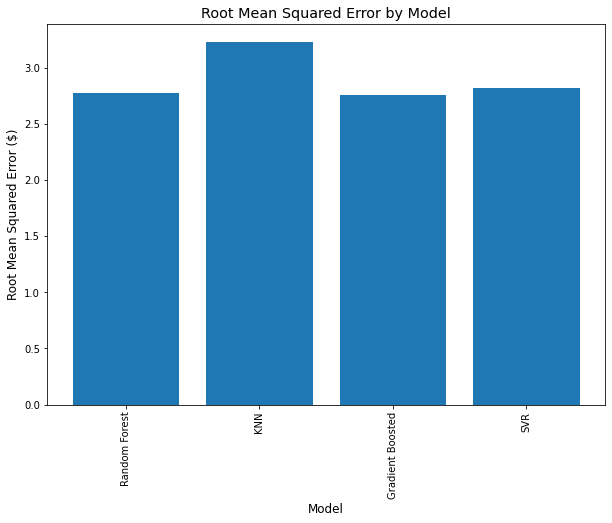

In [33]:
plt.figure(figsize=(10,7))
plt.bar(models, scores.RMSE)
plt.xticks(rotation=90)
plt.xlabel('Model', size='large')
plt.ylabel('Root Mean Squared Error ($)', size='large')
plt.title('Root Mean Squared Error by Model', size='x-large');

### Testing against test data and plotting residuals

Based on cross-validation it seems that decision-tree based regression models as well as KNN regression performs the best.  While the SVR model did recieve better scores, it also raised error warnings that the model is not converging, so I won't be using it going forward.  I'm going to test their performance against my test data as well as take the opportunity to plot their residuals.  

***Finally got RMSE that beats many kaggle competition scores!!!!!!!***


*In order to re-run randomized cv search simply unhash those lines.  They have been commented out after providing results in order to speed up re-running of this notebook*

In [1]:
# function to calculate mean absolute percentage error
def MAPE(true, pred):
    MAPE = np.sum(np.abs((true-pred)/true))/len(true)
    return MAPE

#### Testing a Random Forest model, finding optimal parameters, and plotting residuals for the optimal model

In [35]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
preds = rf.predict(X_test)
preds = preds

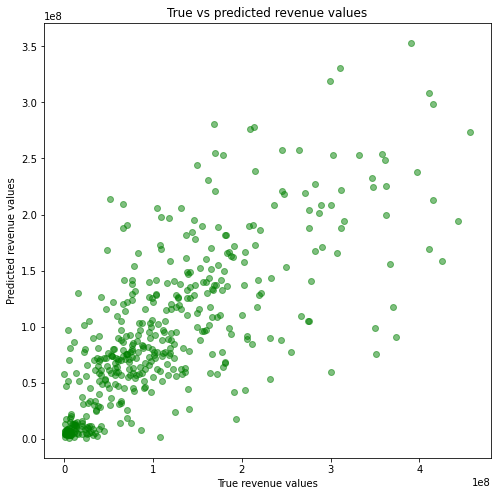

In [38]:
plt.figure(figsize=(8,8))
plt.scatter(np.exp(y_test), np.exp(preds), alpha=0.5, color='g');
plt.xlabel('True revenue values')
plt.ylabel('Predicted revenue values')
plt.title("True vs predicted revenue values");

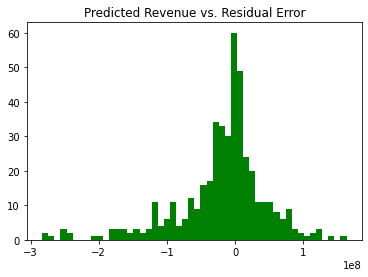

In [39]:
residuals = np.exp(preds)-np.exp(y_test)
plt.hist(residuals,color='g', bins=50)
plt.title('Predicted Revenue vs. Residual Error');

In [40]:
params = {'n_estimators': np.arange(10,1000), 'min_samples_leaf': np.arange(1,10), 'min_samples_split': np.arange(2,10), 
          'max_depth':np.arange(10,90)}
#rand = RandomizedSearchCV(RandomForestRegressor(), param_distributions=params, n_iter=100)
#rand.fit(X_train, y_train)
#rf_best_score = rand.best_score_
#rf_best_params = rand.best_params_
#print(rf_best_score)
#print(rf_best_params)

In [76]:
best_rf = RandomForestRegressor(n_estimators= 166, min_samples_split= 5, min_samples_leaf= 3, max_depth= 43)
best_rf.fit(X_train, y_train)
rf_preds = best_rf.predict(X_test)
rf_r2 = r2_score(y_test, rf_preds)
rf_rmse = np.exp(mean_squared_error(y_test, rf_preds, squared=False))
rf_mape = MAPE(y_test, rf_preds) * 100
RandomForest = {'R2':rf_r2, 'RMSE':rf_rmse, 'MAPE':rf_mape}
rf_residuals = np.exp(rf_preds) - np.exp(y_test)

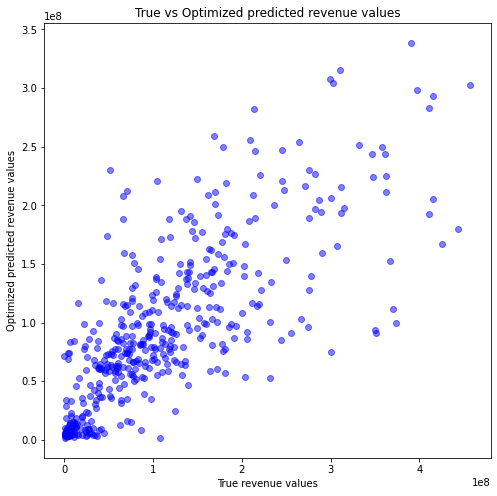

In [43]:
plt.figure(figsize=(8,8))
plt.scatter(np.exp(y_test), np.exp(rf_preds), alpha=0.5, color='b');
plt.xlabel('True revenue values')
plt.ylabel('Optimized predicted revenue values')
plt.title("True vs Optimized predicted revenue values");

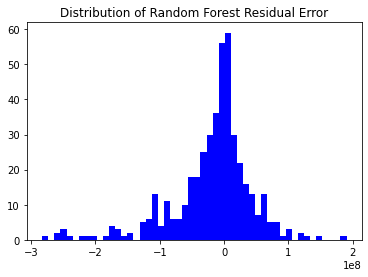

In [46]:
plt.hist(rf_residuals, color='b', bins=50)
plt.title('Distribution of Random Forest Residual Error');

### Testing a Gradient Boosted model, finding optimal parameters and plotting residuals

In [32]:
grade = GradientBoostingRegressor()
grade.fit(X_train, y_train)
preds = grade.predict(X_test)

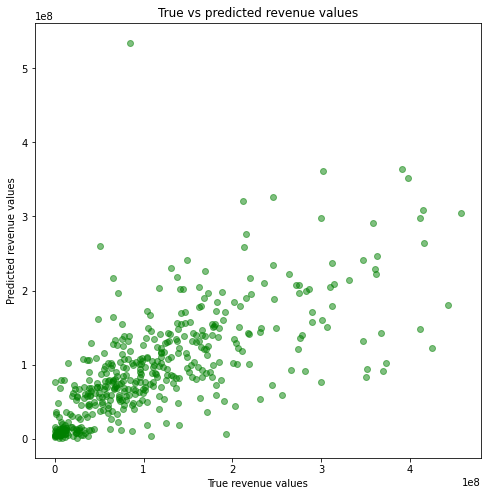

In [49]:
plt.figure(figsize=(8,8))
plt.scatter(np.exp(y_test), np.exp(preds), alpha=0.5, color='g')
plt.xlabel('True revenue values')
plt.ylabel('Predicted revenue values')
plt.title("True vs predicted revenue values");

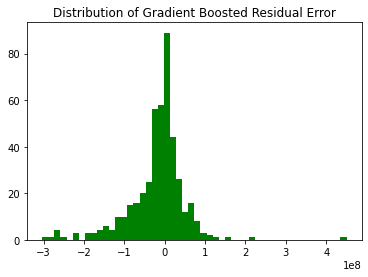

In [51]:
residuals = np.exp(preds)-np.exp(y_test)
plt.hist(residuals,color='g', bins=50)
plt.title('Distribution of Gradient Boosted Residual Error');

In [33]:
params = {'n_estimators':np.arange(100,10000), 'max_depth':np.arange(3,90), 'min_samples_split': np.arange(2,10)}
gradient = RandomizedSearchCV(grade, param_distributions=params, n_iter=100)
gradient.fit(X_train, y_train)
grade_best_score = gradient.best_score_
grade_best_params = gradient.best_params_
print('GB best score: ', grade_best_score)
print('GB best parameters: ', grade_best_params)

GB best score:  0.5229323573537881
GB best parameters:  {'n_estimators': 6542, 'min_samples_split': 7, 'max_depth': 8}


In [36]:
best_gradient=GradientBoostingRegressor(n_estimators= 6542, min_samples_split= 7, max_depth= 8)
best_gradient.fit(X_train, y_train)
grade_preds = best_gradient.predict(X_test)
grade_r2 = r2_score(y_test, grade_preds)
grade_rmse = np.exp(mean_squared_error(y_test, grade_preds, squared=False))
grade_mape = MAPE(y_test, grade_preds) * 100
GradientBoosted = {'R2':grade_r2, 'RMSE':grade_rmse, 'MAPE':grade_mape}
gb_residuals = np.exp(grade_preds)-np.exp(y_test)

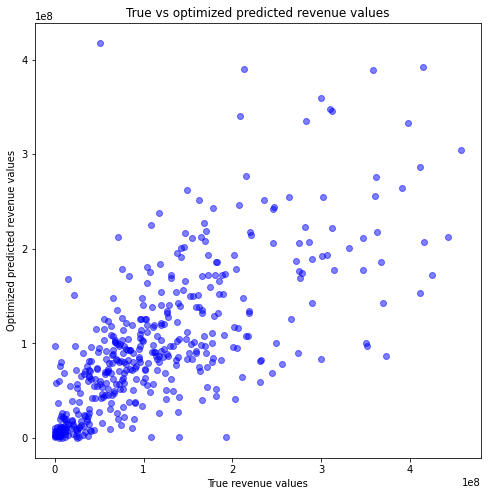

In [37]:
plt.figure(figsize=(8,8))
plt.scatter(np.exp(y_test), np.exp(grade_preds), alpha=0.5, color='b')
plt.xlabel('True revenue values')
plt.ylabel('Optimized predicted revenue values')
plt.title("True vs optimized predicted revenue values");

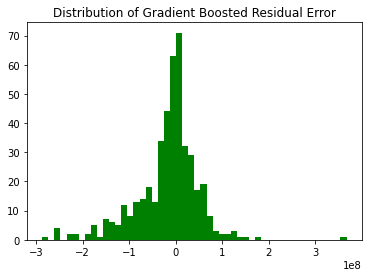

In [38]:
plt.hist(gb_residuals, color='g', bins=50)
plt.title('Distribution of Gradient Boosted Residual Error');

### Testing a K-Nearest Neighbors model, finding optimal parameters, and plotting residuals

In [60]:
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
preds = knn.predict(X_test)

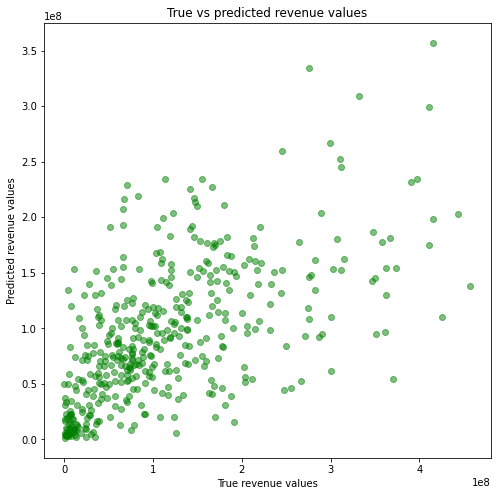

In [63]:
plt.figure(figsize=(8,8))
plt.scatter(np.exp(y_test), np.exp(preds), alpha=0.5, color='g')
plt.xlabel('True revenue values')
plt.ylabel('Predicted revenue values')
plt.title("True vs predicted revenue values");

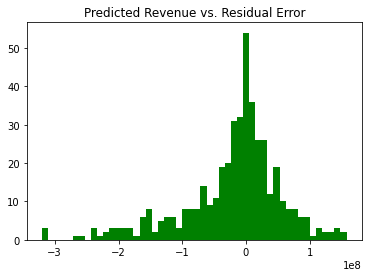

In [61]:
residuals = np.exp(preds)-np.exp(y_test)
plt.hist(residuals,color='g', bins=50)
plt.title('Predicted Revenue vs. Residual Error');

In [65]:
params = {'n_neighbors':np.arange(2,89)}
#KNN = RandomizedSearchCV(knn, param_distributions=params, n_iter=87)
#KNN.fit(X_train, y_train)
#knn_best_score = KNN.best_score_
#knn_best_params = KNN.best_params_
#print('GB best score: ', knn_best_score)
#print('GB best parameters: ', knn_best_params)

In [78]:
best_knn = KNeighborsRegressor(n_neighbors= 15)
best_knn.fit(X_train, y_train)
knn_preds = best_knn.predict(X_test)
knn_r2 = r2_score(y_test, knn_preds)
knn_rmse = np.exp(mean_squared_error(y_test, knn_preds, squared=False))
knn_mape = MAPE(y_test, preds) * 100
KNN = {'R2':knn_r2, 'RMSE':knn_rmse, 'MAPE':knn_mape}
residuals = np.exp(knn_preds)-np.exp(y_test)

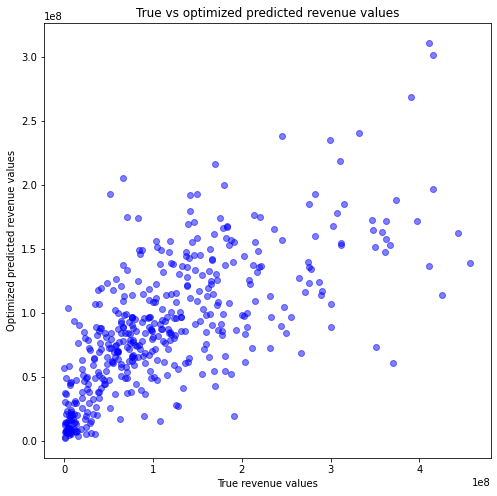

In [67]:
plt.figure(figsize=(8,8))
plt.scatter(np.exp(y_test), np.exp(knn_preds), alpha=0.5, color='b')
plt.xlabel('True revenue values')
plt.ylabel('Optimized predicted revenue values')
plt.title("True vs optimized predicted revenue values");

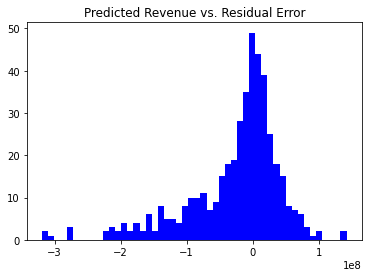

In [69]:
residuals = np.exp(knn_preds)-np.exp(y_test)
plt.hist(residuals,color='b', bins=50)
plt.title('Predicted Revenue vs. Residual Error');

In [80]:
dict_ = {'Random Forest':RandomForest, 'Gradient Boosting':GradientBoosted, 'K-nearest Neighbors':KNN}
opti_scores = pd.DataFrame(dict_)
opti_scores = opti_scores.T
opti_scores

,R2,RMSE,MAPE
Random Forest,0.57859,2.45184,1699.61131
Gradient Boosting,0.40007,2.91559,1700.12747
K-nearest Neighbors,0.54478,2.53990,1699.23703


<ipython-input-85-ce0f9c7268fb>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(models, rotation=45)
<ipython-input-85-ce0f9c7268fb>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(models, rotation=45)
<ipython-input-85-ce0f9c7268fb>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(models, rotation=45);


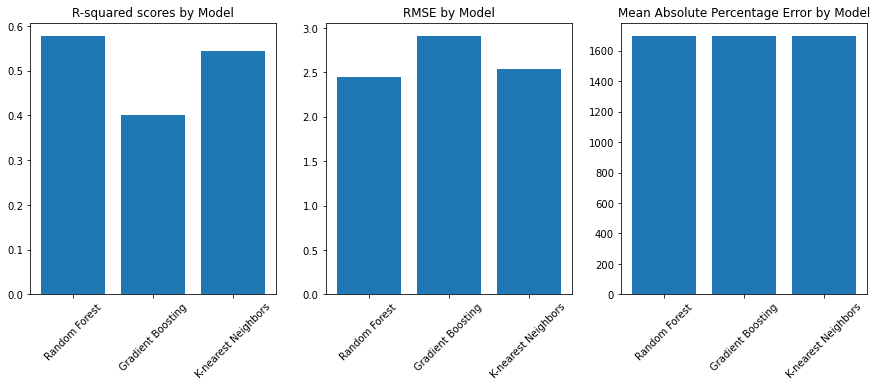

In [85]:
models = list(opti_scores.index)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 5))
fig.figure
ax1.bar(models, opti_scores.R2)
ax1.set_title('R-squared scores by Model')
ax1.set_xticklabels(models, rotation=45)
ax2.bar(models, opti_scores.RMSE)
ax2.set_title('RMSE by Model')
ax2.set_xticklabels(models, rotation=45)
ax3.bar(models, opti_scores.MAPE)
ax3.set_title('Mean Absolute Percentage Error by Model')
ax3.set_xticklabels(models, rotation=45);

## Conclusion

Based on the results here the random forest regression model performed the best of all of these models, which is surprising.  What is also surprising is that while the Root Mean Squared Error scores for all models is less than 3, the absolute percentage error scores are all within 1% of 1,700%.  This is both higher than the percent error scores recieved on out of the box models, including linear models from previous notebooks.  

Because the error is so consistently identical, unlike other scoring metrics, and because the rise in percentage error does not reflect the drop in RMSE score or improvement in R-squared scores; I believe that the percentage error scores are erroneous. Since I wrote that function myself and have yet to make scikit-learn behave and allow me to upgrate to version 0.24 where the MAPE scoring function is provided my time for now is best spent moving to the final section of my project and I can later come back and take a closer look at what is oging on with my percentage error metrics. 